In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import datetime

from scipy import interpolate

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
#register_matplotlib_converters()

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from math import sqrt

from tqdm import tqdm_notebook
from itertools import product


import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# Setup

In [2]:
# Bank data, total amount of money on checking accounts.

df = pd.read_csv('../input/bank-data/bank_data.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [3]:
df

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149
...,...,...
2106,06.10.2019,64630140507
2107,07.10.2019,66115288637
2108,08.10.2019,68424049766
2109,09.10.2019,72492897583


In [4]:
# Lets convert 'REPORTDATE' to date_time type and copy it to index

df['date'] = pd.to_datetime(df.REPORTDATE, format = '%d.%m.%Y')
df['ind'] = df.index + 1

df = df.set_index(df['date']).asfreq('d')

# EDA

<AxesSubplot:xlabel='date'>

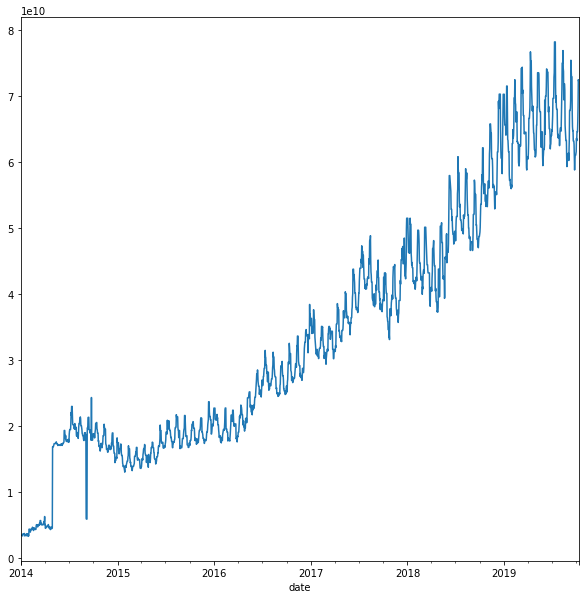

In [5]:
# Lets visualize the data

df['VALUE'].plot(figsize=(10, 10))

In [6]:
# From the data above we can see clearly that data is not stationary,
# but I will run a Augmented Dickey Fuller test

result = adfuller(df.VALUE)
result

(-0.22889387824481777,
 0.9349887607019655,
 26,
 2084,
 {'1%': -3.4334917336814543,
  '5%': -2.862927879505365,
  '10%': -2.567508842556946},
 93050.22128773549)

In [7]:
# As expected test shows df.VALUE is not stationary because p value is 0.93 . 
# This value is greater than 0.05 to suspect statinarity in this data.

(-19.570715919690826,
 0.0,
 25,
 2084,
 {'1%': -3.4334917336814543,
  '5%': -2.862927879505365,
  '10%': -2.567508842556946},
 93004.6443888639)

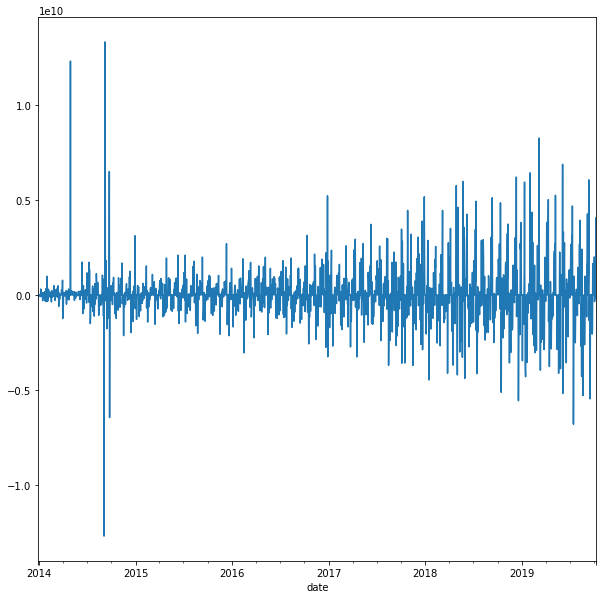

In [8]:
# This time lets take first difference and then I will check for stationarity again.

df['delta_1'] = df.VALUE.diff()

df['delta_1'].plot(figsize=(10, 10))

adfuller(df.delta_1[1:])

<AxesSubplot:xlabel='date'>

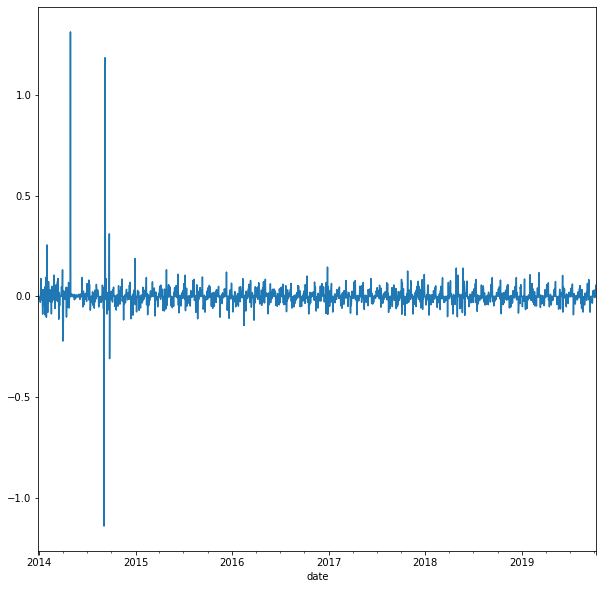

In [9]:
# This time Augmented Dickey Fuller test returns p value of 0.
# It means we can suspect strong stationarity in data.
# I think by taking a log, it will reduce heteroscedasticity.

df['log'] = np.log(df.VALUE)
df['log_df'] = df['log'].diff()


df['log_df'].plot(figsize=(10, 10))

In [10]:
# As I expected this image shows great reduction in heteroscedasticity

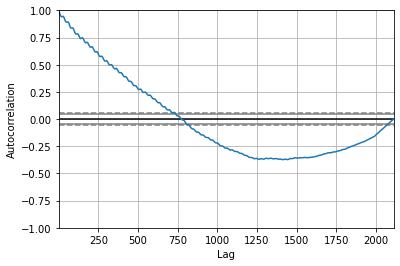

In [11]:
# I will take a look at autocorrelation graph

autocorrelation_plot(df.VALUE)
plt.show()

In [12]:
# It shows that lag correlation slowly decrease.

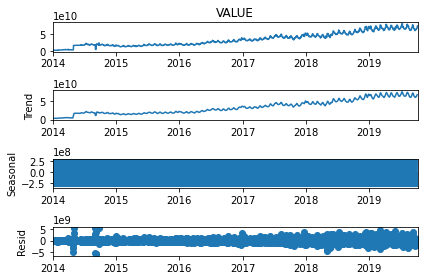

In [13]:
# Lets look at decomposition graph

decomposition = seasonal_decompose(df.VALUE) 
decomposition.plot()
plt.show() 

In [14]:
adfuller(decomposition.resid[3:-3])



(-23.129890893052156,
 0.0,
 26,
 2078,
 {'1%': -3.4335008163402327,
  '5%': -2.8629318897058345,
  '10%': -2.5675109777577276},
 90940.8165783585)

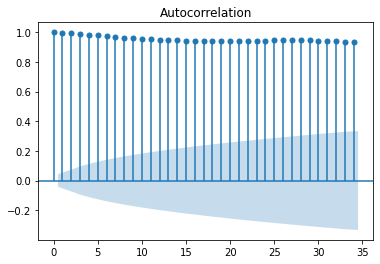

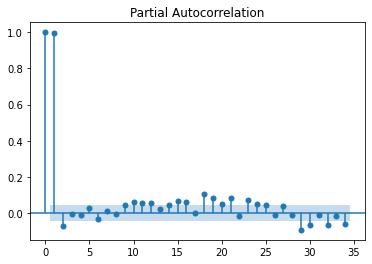

In [15]:
plot_acf(df.VALUE);
plot_pacf(df.VALUE);

# Single HWES

In [16]:



def eval_graph_rmse(test, predictions):
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.figure(figsize = (16,16))
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

In [17]:
# Set the value of Alpha and define m (Time Period)
m = 7
alpha = 1/(2*m)

# I decided to use 7 for m value, because in decomposition of data,
# I see seasonal part repeats after 7 days. 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



<AxesSubplot:title={'center':'Holt Winters Single Exponential Smoothing'}, xlabel='date'>

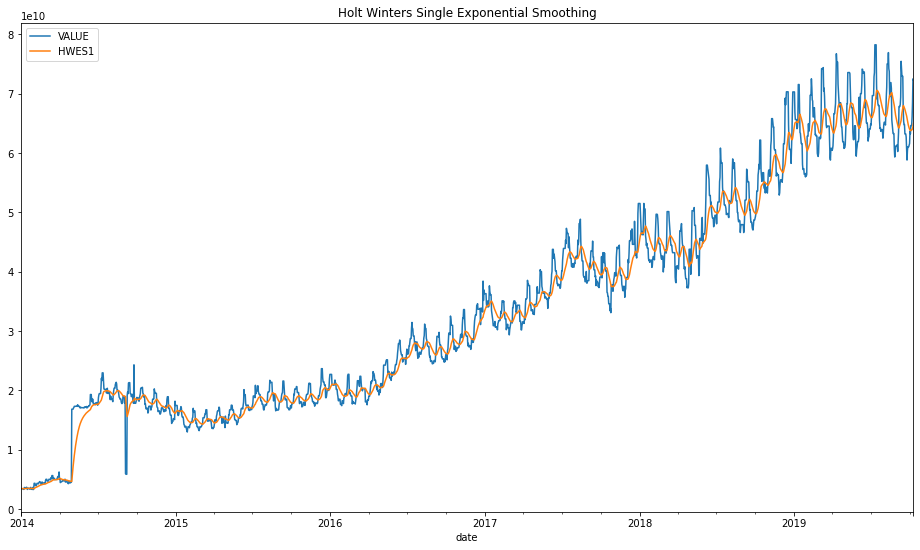

In [18]:
df['HWES1'] = SimpleExpSmoothing(df['VALUE']).fit(
    smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues

df[['VALUE', 'HWES1']].plot(
    title='Holt Winters Single Exponential Smoothing', figsize=(16, 9))

In [19]:


# From the graph above we can see that this model is not very good.
# I will not even evaluate it on walk-forward validation

# Double HWES

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



<AxesSubplot:title={'center':'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='date'>

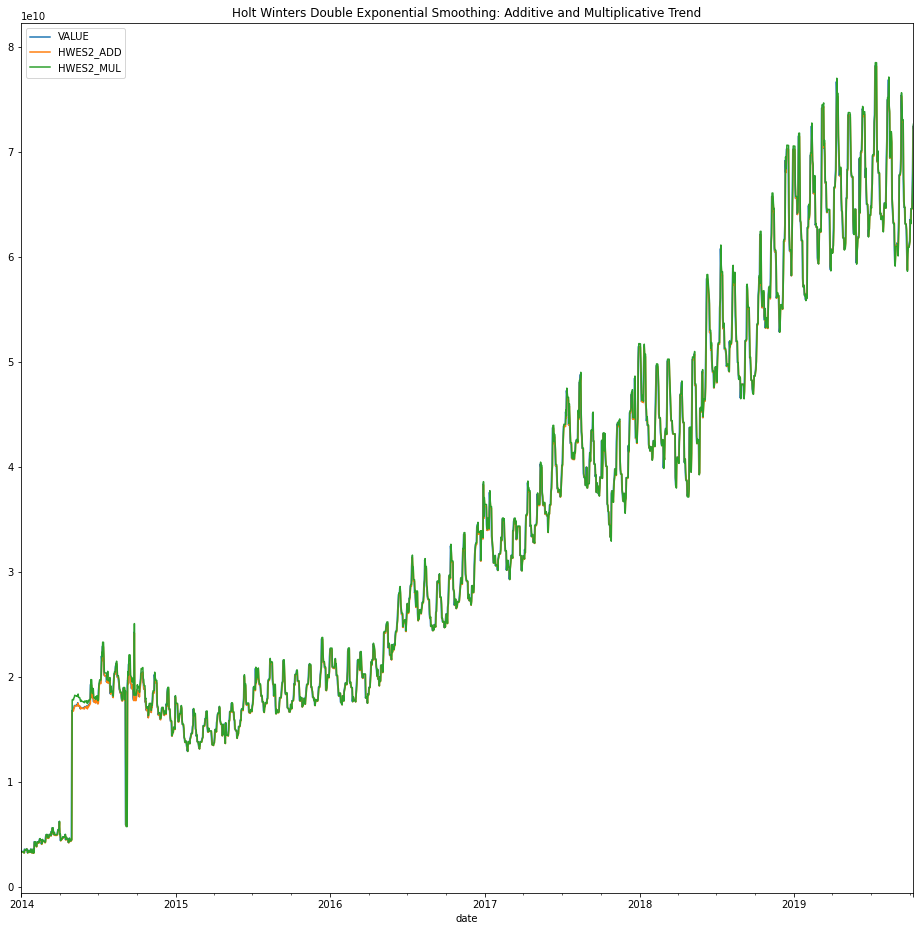

In [20]:
df['HWES2_ADD'] = ExponentialSmoothing(
    df['VALUE'], trend='add').fit().fittedvalues
df['HWES2_MUL'] = ExponentialSmoothing(
    df['VALUE'], trend='mul').fit().fittedvalues
df[['VALUE', 'HWES2_ADD', 'HWES2_MUL']].plot(
    title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend', figsize=(16, 16))

# Double HWES walk-forward validation

Test RMSE: 1844190337.147


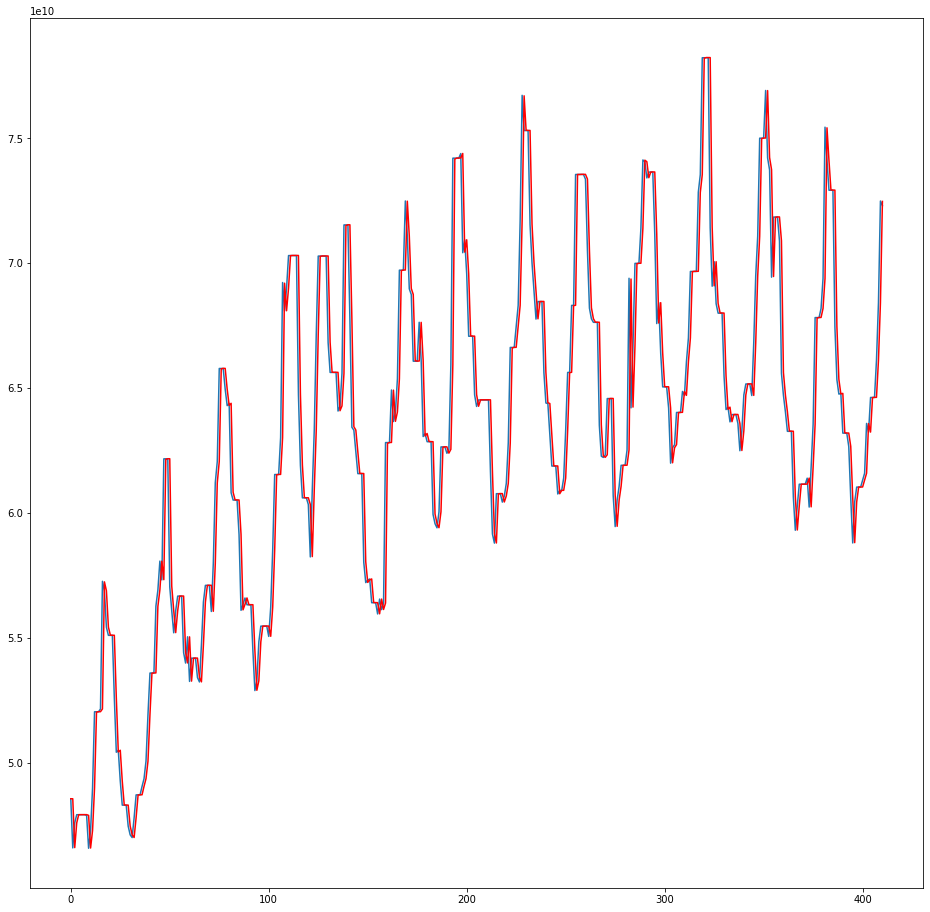

In [21]:
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

warnings.filterwarnings('ignore', 'statsmodels.tsa.holtwinters.ExponentialSmoothing',
                        FutureWarning)


    



X = df['VALUE'].values

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # Line that is not converging

    train, test = X[200:1700], X[1700:]
    history = [x for x in train]
    predictions = list()
    #statsmodels.tsa.holtwinters.ExponentialSmoothing
    for t in range(len(test)):

        fitted_model = ExponentialSmoothing(history, trend='add').fit()

        test_predictions = fitted_model.forecast()

        yhat = test_predictions[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    

    
eval_graph_rmse(test, predictions)   

In [22]:
#Test RMSE: 1842615465.934

# Triple HWES

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



<AxesSubplot:title={'center':'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='date'>

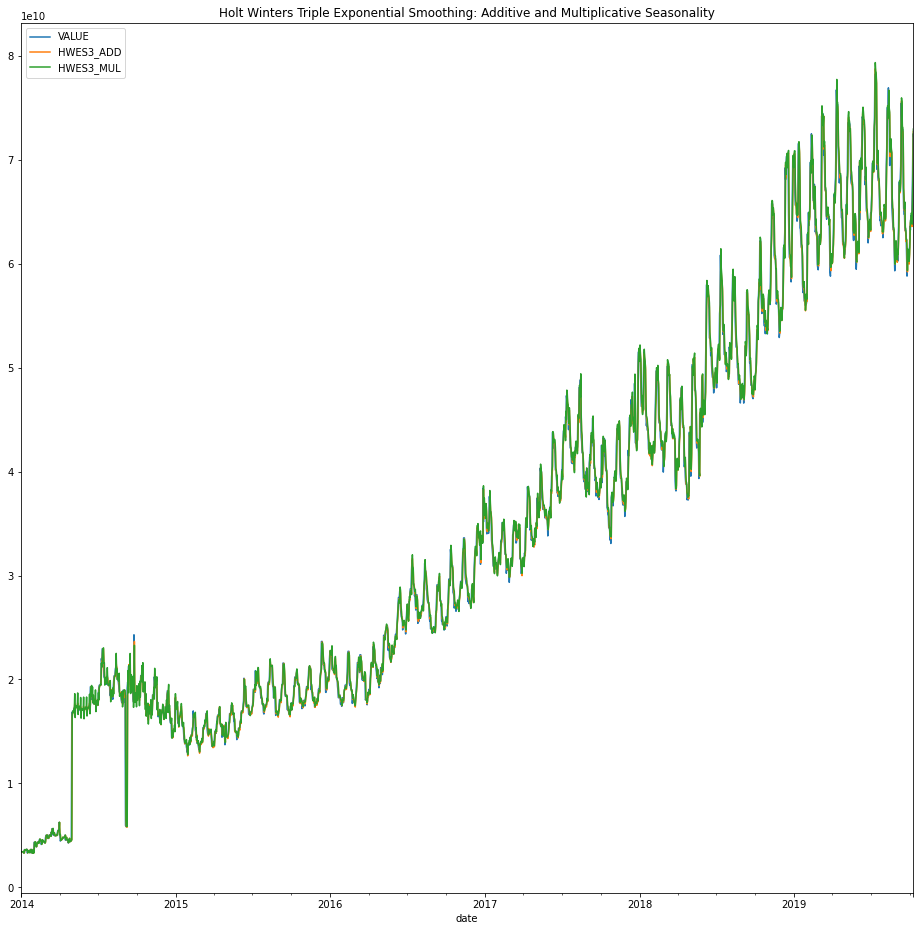

In [23]:
df['HWES3_ADD'] = ExponentialSmoothing(
    df['VALUE'], trend='add', seasonal='add', seasonal_periods=7).fit().fittedvalues
df['HWES3_MUL'] = ExponentialSmoothing(
    df['VALUE'], trend='mul', seasonal='mul', seasonal_periods=7).fit().fittedvalues
df[['VALUE', 'HWES3_ADD', 'HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality',
                                             figsize=(16, 16))

# Triple HWES walk-forward validation

Test RMSE: 1811974161.410


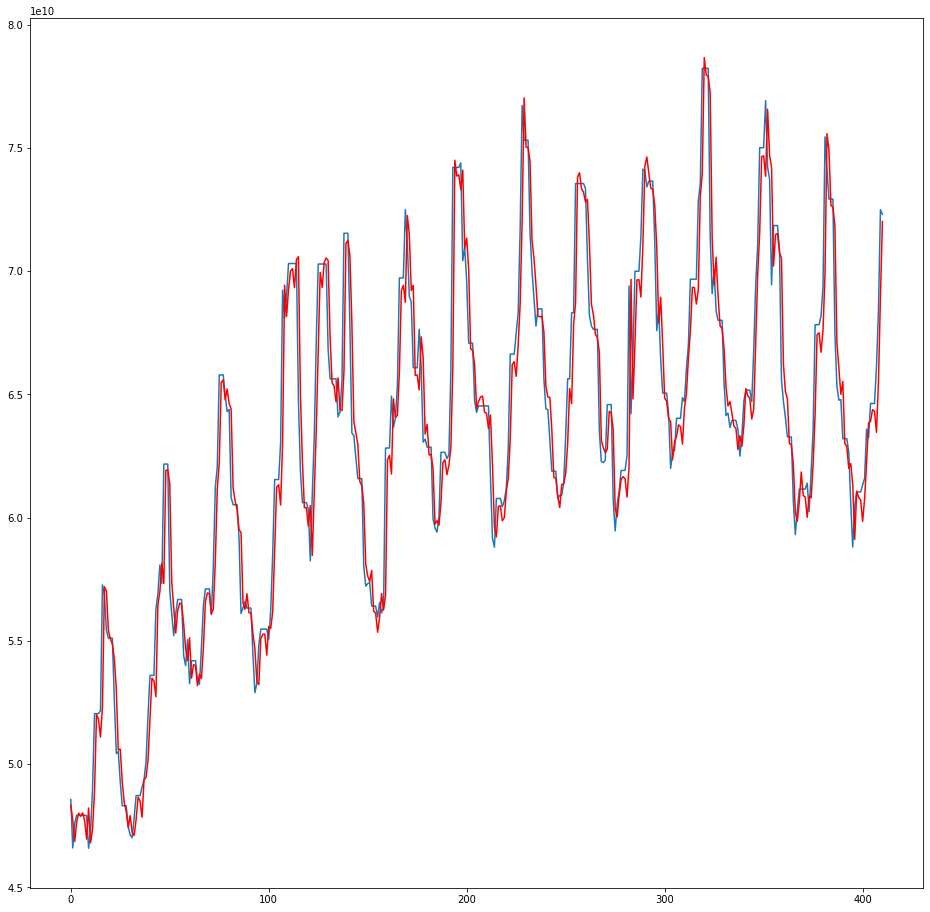

In [24]:
X = df['VALUE'].values

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    

    train, test = X[200:1700], X[1700:]
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        fitted_model = ExponentialSmoothing(history,trend='add',  seasonal='add', seasonal_periods=7).fit()
        

        
        test_predictions = fitted_model.forecast()
        
        yhat = test_predictions[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        


    eval_graph_rmse(test, predictions)   

In [25]:
# Test RMSE: 1839907470.709 It gave better value than the first Double HWES

# ARIMA

In [26]:
# To build Arima model, I have to choose the parameters of p,d,q.
# optimization function will help me.


def optimize_ARIMA(parameters_list, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, d, q) tuples
        
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = ARIMA(exog, order=(param[0], param[1], param[2])).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p, d, q', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [27]:
p = range(0, 5, 1)
d = range(0,2,1)
q = range(0, 5, 1)

parameters = product(p, d, q)
parameters_list = list(parameters)
print(len(parameters_list))

50


In [28]:
from statsmodels.tsa.arima_model import ARIMA

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # Line that is not converging

    result_df = optimize_ARIMA(parameters_list, df['VALUE'][200:])
    result_df 

  0%|          | 0/50 [00:00<?, ?it/s]

# Arima walk-forward validation

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ts

Test RMSE: 1822229291.366


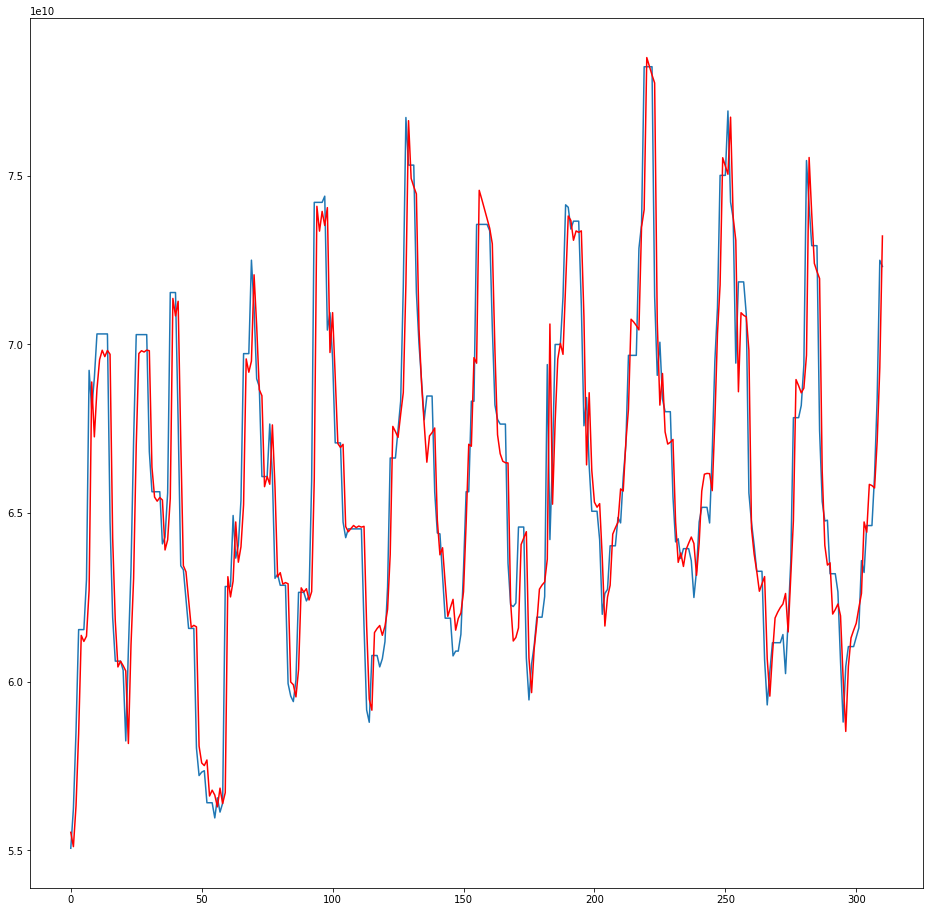

In [29]:
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA


X = df['VALUE'].values



train, test = X[200:1800], X[1800:]
history = [x for x in train]
predictions = list()




for t in range(len(test)):

    fitted_model = ARIMA(history, order=(2,1,2)).fit(disp=0)


    test_predictions = fitted_model.forecast()

    yhat = test_predictions[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)




eval_graph_rmse(test, predictions)   

In [30]:
#Test RMSE: 1740867673.443 for Arima model is better than for both HWES models

# Sarima

In [31]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [32]:
p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [33]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 7, df['VALUE'][200:])
result_df 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/81 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,"(p,q)x(P,Q)",AIC
0,"(0, 0, 2, 2)",8.526541e+04
1,"(0, 0, 2, 1)",8.529368e+04
2,"(0, 0, 1, 2)",8.533247e+04
3,"(0, 0, 0, 2)",8.534831e+04
4,"(0, 0, 1, 1)",8.536210e+04
...,...,...
76,"(2, 0, 0, 0)",8.654814e+04
77,"(1, 0, 0, 0)",8.655332e+04
78,"(0, 2, 0, 0)",8.655364e+04
79,"(0, 1, 0, 0)",8.655753e+04


Test RMSE: 1934226722.966


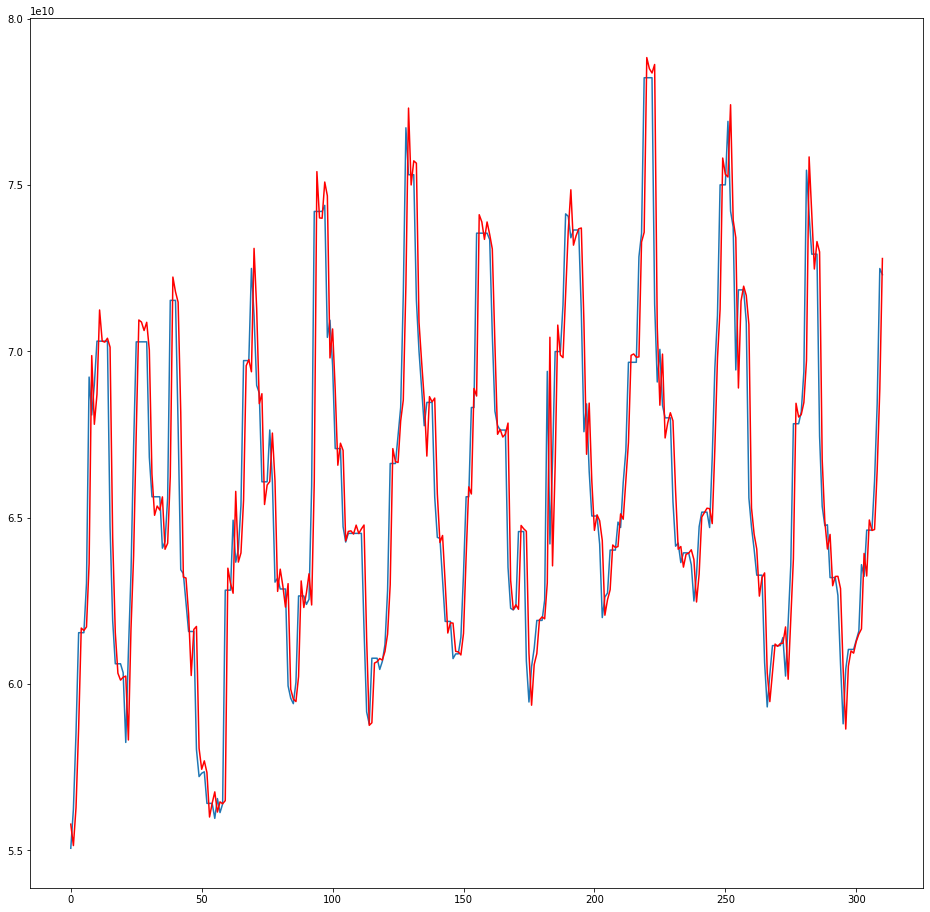

In [34]:
from statsmodels.tsa.arima.model import ARIMA

X = df['VALUE'].values



train, test = X[300:1800], X[1800:]
history = [x for x in train]
predictions = list()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for t in range(len(test)):

        fitted_model=sm.tsa.statespace.SARIMAX(history,order=(3, 1, 2),seasonal_order=(2,1,1,4)).fit(disp=-1)
        test_predictions = fitted_model.forecast()


        yhat = test_predictions[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)



    eval_graph_rmse(test, predictions)   

In [35]:
df

,REPORTDATE,VALUE,date,ind,delta_1,log,log_df,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
date,,,,,,,,,,,,
2013-12-30,30.12.2013,3457625638,2013-12-30,1,NaN,21.963848,NaN,3.457626e+09,3.417092e+09,3.417092e+09,3.470116e+09,3.470107e+09
2013-12-31,31.12.2013,3417092149,2013-12-31,2,-4.053349e+07,21.952056,-0.011792,3.457626e+09,3.416894e+09,3.417847e+09,3.430085e+09,3.429925e+09
2014-01-01,01.01.2014,3417092149,2014-01-01,3,0.000000e+00,21.952056,0.000000,3.454730e+09,3.376562e+09,3.377964e+09,3.430104e+09,3.429944e+09
2014-01-02,02.01.2014,3417092149,2014-01-02,4,0.000000e+00,21.952056,0.000000,3.452042e+09,3.376364e+09,3.378689e+09,3.430104e+09,3.429944e+09
2014-01-03,03.01.2014,3417092149,2014-01-03,5,0.000000e+00,21.952056,0.000000,3.449546e+09,3.376367e+09,3.379598e+09,3.430103e+09,3.429943e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-06,06.10.2019,64630140507,2019-10-06,2107,0.000000e+00,24.891947,0.000000,6.388645e+10,6.460265e+10,6.463288e+10,6.442873e+10,6.479763e+10
2019-10-07,07.10.2019,66115288637,2019-10-07,2108,1.485148e+09,24.914666,0.022719,6.393957e+10,6.460269e+10,6.463285e+10,6.357886e+10,6.380351e+10
2019-10-08,08.10.2019,68424049766,2019-10-08,2109,2.308761e+09,24.948990,0.034324,6.409498e+10,6.608056e+10,6.614638e+10,6.560463e+10,6.565737e+10


# Downsampling

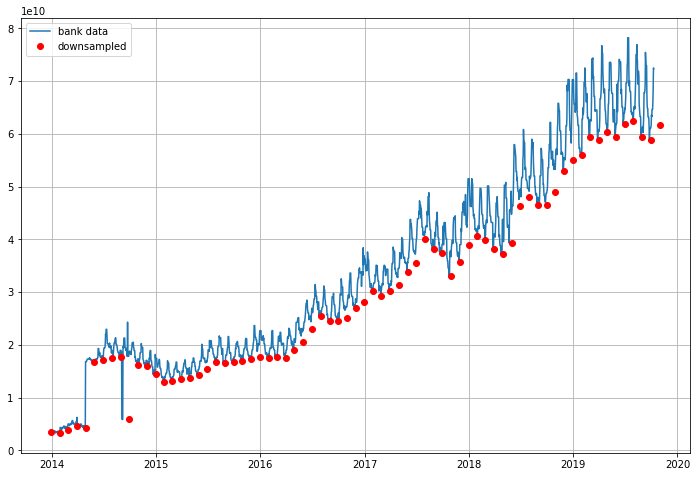

,VALUE
date,
2013-12-31,3417092149
2014-01-31,3282809762
2014-02-28,3885884141
2014-03-31,4699421840
2014-04-30,4270597450


In [36]:
#I will downsample data to build models that predict minimum monthly money amount bank
# has to keep.





conversion = {
    'VALUE' :  'min'}   

## downsampling 




#df = df.set_index('ts')

downsampled = df.resample('M').apply(conversion)

#df = df.reset_index()
#downsampled = downsampled.reset_index()


f, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.VALUE)
ax.plot(downsampled.VALUE, c='r', marker='o', lw=0)
ax.legend(['bank data', 'downsampled'])
ax.grid()
plt.show()

downsampled.head()

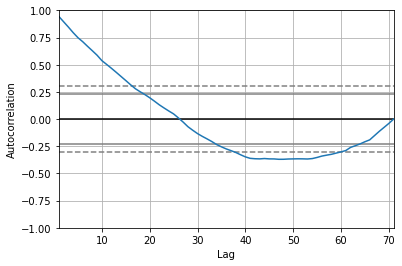

In [37]:
autocorrelation_plot(downsampled.VALUE)
plt.show()

<AxesSubplot:xlabel='date'>

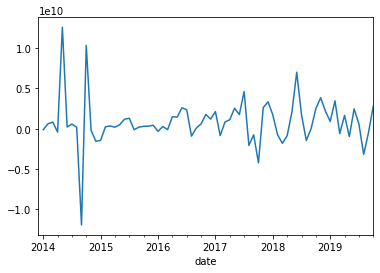

In [38]:
downsampled.VALUE.diff().plot()

In [39]:
adfuller(downsampled.VALUE.diff()[1:])

(-6.197261366374881,
 5.9237858383573475e-08,
 2,
 67,
 {'1%': -3.5319549603840894,
  '5%': -2.905755128523123,
  '10%': -2.5903569458676765},
 2632.776626427971)

In [40]:
# It takes to take one difference to make this data stationary

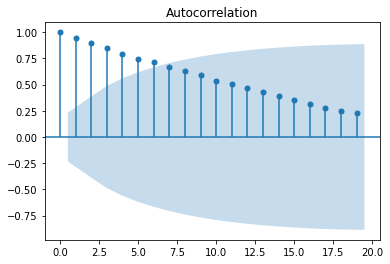

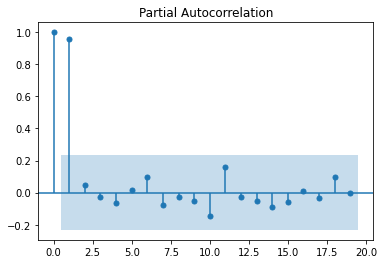

In [41]:
plot_acf(downsampled.VALUE);
plot_pacf(downsampled.VALUE);

In [42]:
# Plots above give hint that in Arima model p = 1 and q = 5

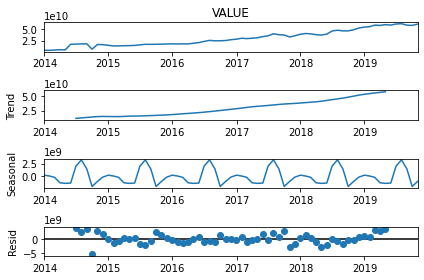

In [43]:
decomposition = seasonal_decompose(downsampled.VALUE) 
decomposition.plot()
plt.show() 

# Arima model optimization

In [44]:
p = range(0, 5, 1)
d = range(0,2,1)
q = range(0, 6, 1)

parameters = product(p, d, q)
parameters_list = list(parameters)
print(len(parameters_list))

60


In [45]:
from statsmodels.tsa.arima_model import ARIMA

result_df = optimize_ARIMA(parameters_list, downsampled.VALUE[11:])
result_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/60 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:

,"p, d, q",AIC
0,"(3, 1, 0)",2681.374855
1,"(3, 1, 4)",2681.598621
2,"(2, 1, 2)",2682.222783
3,"(3, 1, 5)",2682.588455
4,"(4, 1, 0)",2682.639821
5,"(3, 1, 1)",2682.875100
6,"(4, 1, 3)",2683.126550
7,"(4, 1, 2)",2683.441299
8,"(4, 1, 4)",2683.582548
9,"(4, 1, 1)",2683.820740


Test RMSE: 2237078824.767


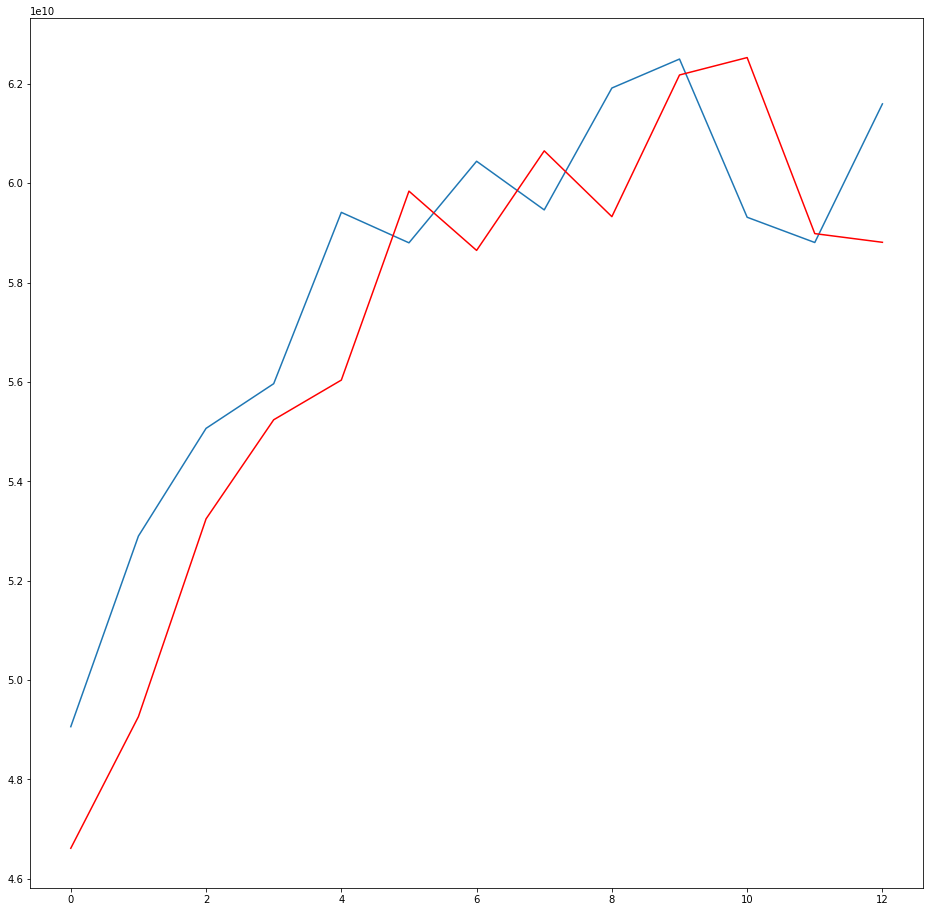

In [46]:
from statsmodels.tsa.arima.model import ARIMA

X = downsampled.VALUE.values



train, test = X[11:58], X[58:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    
    fitted_model = ARIMA(history, order=(1,1,1)).fit()
   
    
    test_predictions = fitted_model.forecast()
    
    #output = model_fit.forecast()
    yhat = test_predictions[0] #+ 1700000000
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

    
eval_graph_rmse(test, predictions)   

<AxesSubplot:xlabel='date'>

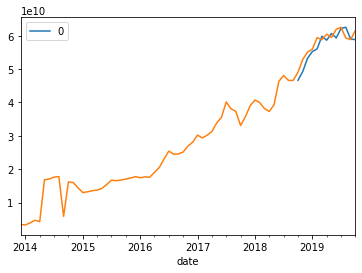

In [47]:
#downsampled['ARIMA'] = ARIMA(downsampled['VALUE'][11:], order=(1,1,1)).fit()

pd.DataFrame(data = predictions, index = downsampled.index[58:]).plot()
downsampled['VALUE'].plot()

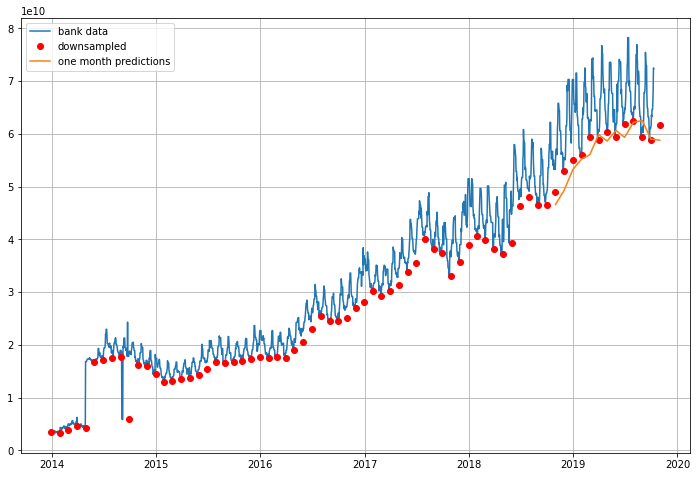

In [48]:



f, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.VALUE)
ax.plot(downsampled.VALUE, c='r', marker='o', lw=0)
ax.plot(pd.DataFrame(data = predictions, index = downsampled.index[58:]))
ax.legend(['bank data', 'downsampled', 'one month predictions'])
ax.grid()
plt.show()

# 2 Month

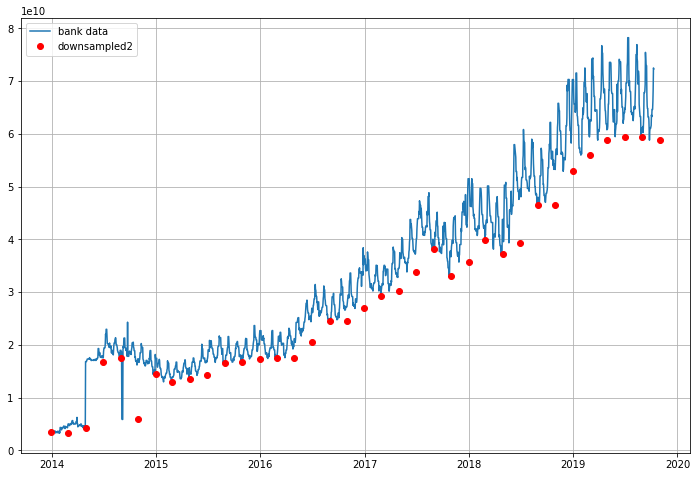

,VALUE
date,
2013-12-31,3417092149
2014-02-28,3282809762
2014-04-30,4270597450
2014-06-30,16828540812
2014-08-31,17600814179


In [49]:
conversion = {
    'VALUE' :  'min'}   


downsampled2 = df.resample('2M').apply(conversion)


f, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.VALUE)
ax.plot(downsampled2.VALUE, c='r', marker='o', lw=0)
ax.legend(['bank data', 'downsampled2'])
ax.grid()
plt.show()

downsampled2.head()



Test RMSE: 2874875801.354


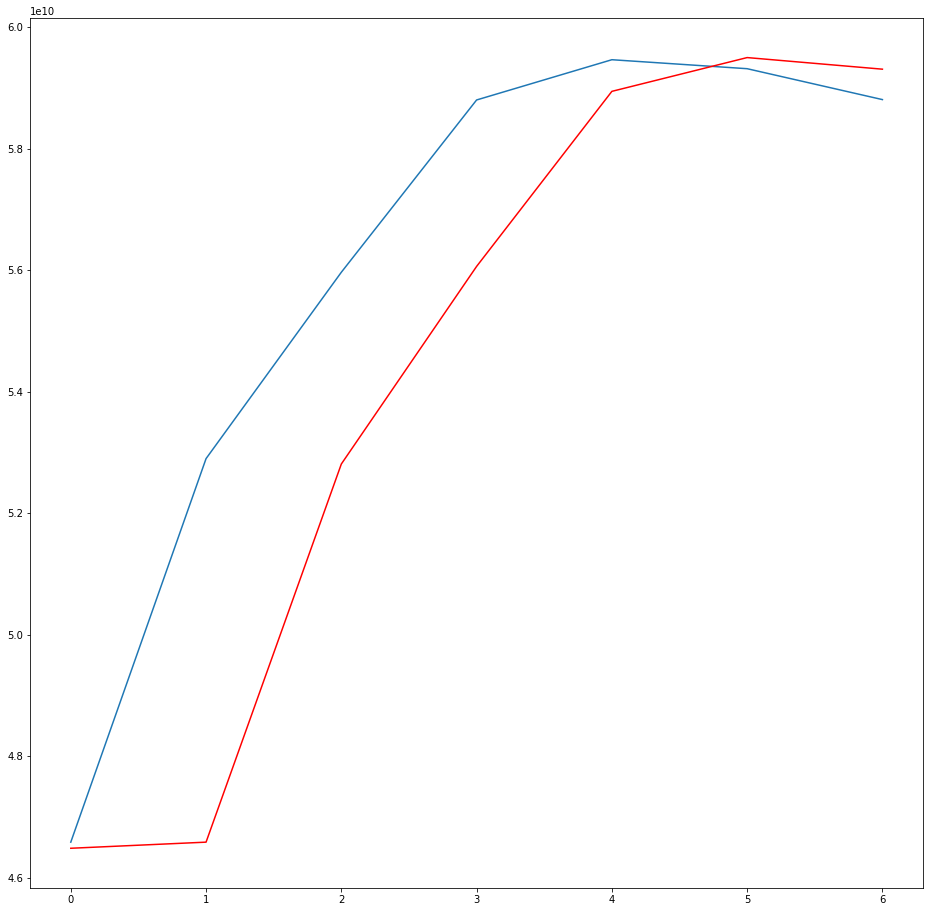

In [50]:
X = downsampled2.VALUE.values


train, test = X[6:29], X[29:]
history = [x for x in train]
predictions2 = list()
# walk-forward validation
for t in range(len(test)):
    
    fitted_model = ARIMA(history, order=(1,1,0)).fit()
   
    
    test_predictions = fitted_model.forecast()
    
    #output = model_fit.forecast()
    yhat = test_predictions[0] 
    predictions2.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

    
eval_graph_rmse(test, predictions2) 


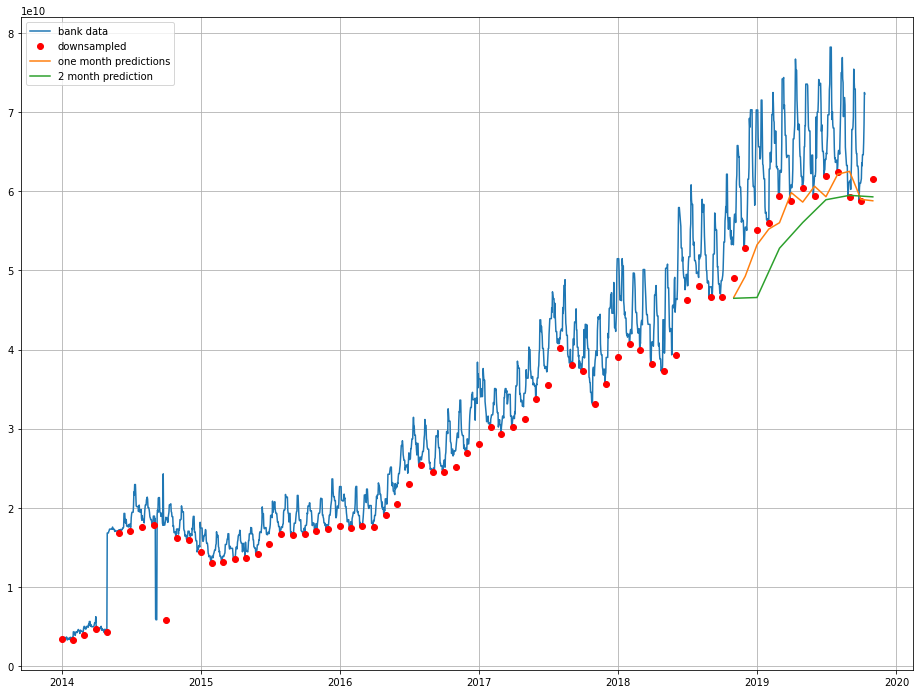

In [51]:
f, ax = plt.subplots(figsize=(16, 12))
ax.plot(df.VALUE)
ax.plot(downsampled.VALUE, c='r', marker='o', lw=0)
ax.plot(pd.DataFrame(data = predictions, index = downsampled.index[58:]))
ax.plot(pd.DataFrame(data = predictions2, index = downsampled2.index[29:]))
ax.legend(['bank data', 'downsampled', 'one month predictions', '2 month prediction'])
ax.grid()
plt.show()

Test RMSE: 2748484326.383


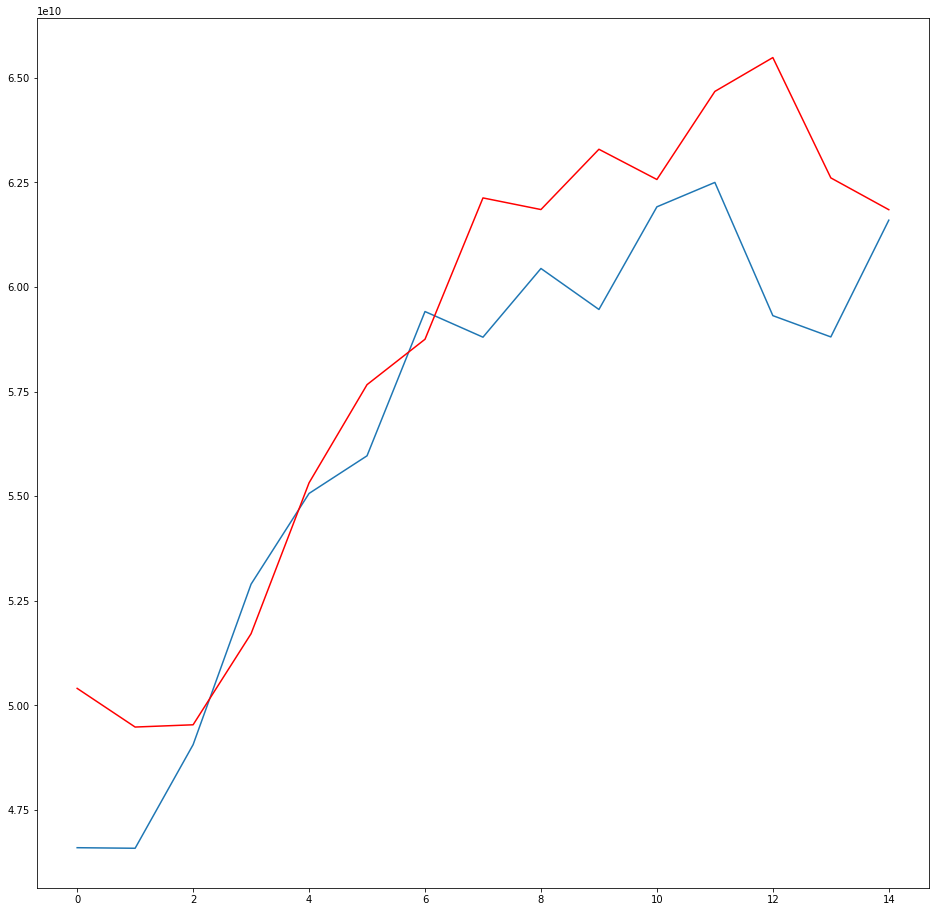

In [52]:
X = downsampled.VALUE.values



train, test = X[:56], X[56:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    #fitted_model = ExponentialSmoothing(history,trend='add',  seasonal='mul', seasonal_periods=4).fit()
    fitted_model = ARIMA(history, order=(1,1,1)).fit()
   
    #fitted_model=sm.tsa.statespace.SARIMAX(history,order=(3, 1, 2),seasonal_order=(2,1,1,7)).fit()
    test_predictions = fitted_model.forecast()
    #model = ARIMA(history, order=(5,1,0))
    #model_fit = model.fit()
    #output = model_fit.forecast()
    yhat = test_predictions[0] + 3000000000
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

    
eval_graph_rmse(test, predictions)   